In [1]:
## Create a Custom Dataset for SVHN database
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Deep_Learning_FP/Data'
results_path = '/content/drive/My Drive/Deep_Learning_FP/Results'

simpson = ImageFolder(root=data_path, transform=ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=simpson,
                                           batch_size=64, 
                                           shuffle=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


torch.Size([64, 3, 64, 64])


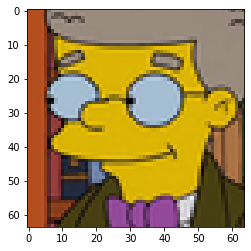

In [2]:
images = next(iter(train_loader))
images_aux = images[0]
print(images_aux.shape)
image = images_aux[10,:,:,:]
plt.imshow(image.permute(1,2,0).squeeze().numpy())
plt.show()  

In [ ]:
# Convolution + BatchNormnalization + ReLU block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn(self.conv(out)))   
    return out

#  BatchNormnalization + ReLU block + Convolution for the decoder
class BNReLUConv(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv(out)
    return out

# Encoder definition with 3 COnv-BN-ReLU blocks and fully-connected layer
class Encoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Encoder, self).__init__()
    self.layer1 = ConvBNReLU(3,base_channels,pooling=False)
    self.layer2 = ConvBNReLU(base_channels,base_channels*2,pooling=True)
    self.layer3 = ConvBNReLU(base_channels*2,base_channels*4,pooling=False)
    self.layer4 = ConvBNReLU(base_channels*4,base_channels*8,pooling=True)
    self.layer5 = ConvBNReLU(base_channels*8,base_channels*16,pooling=False)
    self.fc = nn.Linear(16*16*base_channels*16,out_features)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    return self.fc(out.view(x.shape[0],-1))
    
# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and 
class Decoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Decoder, self).__init__()
    self.base_channels = base_channels
    self.fc = nn.Linear(out_features,16*16*base_channels*16)
    self.layer5 = BNReLUConv(base_channels*16,base_channels*8,pooling=False)
    self.layer4 = BNReLUConv(base_channels*8,base_channels*4,pooling=True)
    self.layer3 = BNReLUConv(base_channels*4,base_channels*2,pooling=False)
    self.layer2 = BNReLUConv(base_channels*2,base_channels,pooling=True)
    self.layer1 = BNReLUConv(base_channels,3,pooling=False)
  
  def forward(self,x):
    out = self.fc(x)
    out = out.view(x.shape[0],self.base_channels*16,16,16)
    out = self.layer5(out)
    out = self.layer4(out)
    out = self.layer3(out)
    out = self.layer2(out)
    out = self.layer1(out)
    return torch.sigmoid(out)

In [ ]:
# Discriminator similar to VAE encoder
class Discriminator(nn.Module):
  def __init__(self, base_channels=16):
    super(Discriminator, self).__init__()
    # last fully connected layer acts as a a binary classifier
    self.classifier = Encoder(1,base_channels)

  # Forward pass obtaining the discriminator probability
  def forward(self,x):
    out = self.classifier(x)
    # use sigmoid to get the real/fake image probability
    return torch.sigmoid(out)

# Generator is defined as VAE decoder
class Generator(nn.Module):
  def __init__(self,in_features,base_channels=16):
    super(Generator, self).__init__()
    self.base_channels = base_channels
    self.in_features = in_features
    self.decoder = Decoder(in_features,base_channels)

  # Generate an image from vector z
  def forward(self,z):
    return torch.sigmoid(self.decoder(z))

  # Sample a set of images from random vectors z
  def sample(self,n_samples=64,device='cpu'):
    samples_unit_normal = torch.randn((n_samples,self.in_features)).to(device)
    return self.decoder(samples_unit_normal)

In [ ]:
# GAN Train function. 
def train_GAN(gen, disc,  train_loader, optimizer_gen, optim_disc,
              num_epochs=10, model_name='gan_mnist.ckpt', device='cpu'):
    gen = gen.to(device)
    gen.train() # Set the generator in train mode
    disc = disc.to(device)
    disc.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list_disc = []
    losses_list_gen = []

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0
        update_generator = True

        for i, (real_imagess) in enumerate(train_loader):
            # Get batch of samples and labels
            real_images = real_imagess[0]
            real_images = real_images.to(device)
            n_images = real_images.shape[0]

            # Forward pass
            # Generate random images with the generator
            fake_images = gen.sample(n_images,device=device)
            
            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_real = disc(real_images)
            prob_fake = disc(fake_images)
            
            # Generator loss
            gen_loss = -torch.log(prob_fake).mean()
            # Discriminator loss
            disc_loss = -0.5*(torch.log(prob_real) + torch.log(1-prob_fake)).mean()

            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              gen_loss.backward()
              optimizer_gen.step()
              update_generator = False
            else:           
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True
                

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        # Save model
        losses_list_disc.append(disc_loss_avg / nBatches)
        losses_list_gen.append(gen_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)

        if ((epoch+1) % 20 == 0 or (epoch+1) == 1):
          n_samples = 64
          x_gen = gan_gen.sample(n_samples,device=device)
          image_grid = make_grid(x_gen.cpu(),nrow=8,padding=1)
          plt.figure(figsize=(8,8))
          plt.title('Generated Images')
          plt.imshow(image_grid.permute(1,2,0).detach().numpy())
          plt.show()       
    return losses_list_disc, losses_list_gen

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import imageio
import numpy as np

# Define Geneartor and Discriminator networks
gan_gen = Generator(64)
gan_disc = Discriminator()

#Initialize indepdent optimizer for both networks
learning_rate_gen = .001
learning_rate_disc = .00008
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = learning_rate_gen, weight_decay=1e-4)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = learning_rate_disc, weight_decay=1e-4)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
losses_list_disc, losses_list_gen = train_GAN(gan_gen,gan_disc, train_loader, optimizer_gen, optimizer_disc,
                      num_epochs=500, model_name='GAN.ckpt', device=device)

In [ ]:
# Loss function iterations
import matplotlib.pyplot as plt
plt.plot(losses_list_disc, label='Discriminator')
plt.plot(losses_list_gen, label='Generator')
plt.legend(loc = 'upper right')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('LOSS ')

In [ ]:
### Generate random samples
gan_gen = Generator(64)
gan_gen.load_state_dict(torch.load(results_path+'/GAN.ckpt'))
gan_gen = gan_gen.to(device)
gan_gen.eval()

n_samples = 64
n_iterpolations =50
z_init = torch.randn((n_samples,64)).to(device)
z_final = torch.randn((n_samples,64)).to(device)

interpolation_images = []
for interp in range(0,n_iterpolations):
  interp_0_1 = float(interp) / (n_iterpolations-1)
  z = z_init*interp_0_1 + z_final*(1-interp_0_1)
  x_rec = gan_gen.decoder(z.to(device))
  image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
  image_grid = image_grid.permute(1,2,0).detach().numpy()

  interpolation_images.append((image_grid*255.0).astype(np.uint8))
interpolation_images += interpolation_images[::-1]

imname = results_path+'/GAN.gif'
imageio.mimsave(imname, interpolation_images, fps=25)